# Conditional Random Field segmentation

## Init

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from pathlib import Path
from collections import OrderedDict
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import r2_score, accuracy_score
import datetime as dt
from scipy import signal
import os
from pathlib import Path
from tqdm.auto import tqdm

In [2]:
from segmentation_utils import (
    extract_eef_data_from_rosbag,
    get_ground_truth_segmentation,
)

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence

In [4]:
# %matplotlib ipympl
%load_ext autoreload
%autoreload 2

## Data files

In [5]:
data_path_root = Path("../table-task-ur5e")
data_path_root.exists()

True

In [6]:
bagfiles = list(data_path_root.glob("*.bag"))
bagfiles

[PosixPath('../table-task-ur5e/rosbag2_2025-08-05_21-08-23_2025-08-05-21-08-23.bag'),
 PosixPath('../table-task-ur5e/rosbag2_2025-08-05_21-33-31_2025-08-05-21-33-31.bag'),
 PosixPath('../table-task-ur5e/rosbag2_2025-08-05_21-36-29_2025-08-05-21-36-29.bag'),
 PosixPath('../table-task-ur5e/rosbag2_2025-08-05_21-43-41_2025-08-05-21-43-41.bag'),
 PosixPath('../table-task-ur5e/rosbag2_2025-09-04_18-10-23_2025-09-04-18-10-23_test-image.bag'),
 PosixPath('../table-task-ur5e/rosbag2_2025-09-08_16-33-22_2025-09-08-16-33-23.bag'),
 PosixPath('../table-task-ur5e/rosbag2_2025-09-08_16-35-57_2025-09-08-16-35-57.bag'),
 PosixPath('../table-task-ur5e/rosbag2_2025-09-08_16-53-14_2025-09-08-16-53-14_okayish.bag'),
 PosixPath('../table-task-ur5e/rosbag2_2025-09-08_19-43-25_2025-09-08-19-43-25.bag'),
 PosixPath('../table-task-ur5e/rosbag2_2025-09-08_19-46-18_2025-09-08-19-46-19.bag')]

In [7]:
filenum = -1
bagfile = bagfiles[filenum]
bagfile

PosixPath('../table-task-ur5e/rosbag2_2025-09-08_19-46-18_2025-09-08-19-46-19.bag')

In [8]:
ground_truth_segm_file = data_path_root / "table_task_UR5e_ground_truth.json"
ground_truth_segm_file.exists()

True

## Preprocessing

In [9]:
traj = extract_eef_data_from_rosbag(bagfile)
traj

Extracting TF & gripper data from Bag file...


  0%|          | 0/183488 [00:00<?, ?it/s]

Extracting TF & gripper data from Bag file: done ✓


,x,y,z,timestamp,gripper
0,-0.057518,-0.349359,0.245916,2025-09-08 18:46:19.430824291-05:00,0.01
1,-0.057527,-0.349371,0.245943,2025-09-08 18:46:19.432620296-05:00,0.01
2,-0.057521,-0.349371,0.245940,2025-09-08 18:46:19.434438816-05:00,0.01
3,-0.057525,-0.349373,0.245945,2025-09-08 18:46:19.436862995-05:00,0.01
4,-0.057515,-0.349382,0.245951,2025-09-08 18:46:19.438580443-05:00,0.01
...,...,...,...,...,...
57561,-0.079063,-0.339990,0.226383,2025-09-08 18:48:14.634462638-05:00,0.01
57562,-0.079040,-0.339984,0.226385,2025-09-08 18:48:14.636379567-05:00,0.01
57563,-0.079073,-0.339983,0.226388,2025-09-08 18:48:14.638744970-05:00,0.01
57564,-0.079063,-0.339978,0.226381,2025-09-08 18:48:14.640788775-05:00,0.01


In [10]:
df = traj.diff().mean().timestamp.total_seconds()
df

0.002001

In [11]:
# downsampling = 10

In [12]:
# freq = 1 / (df * downsampling)
# freq

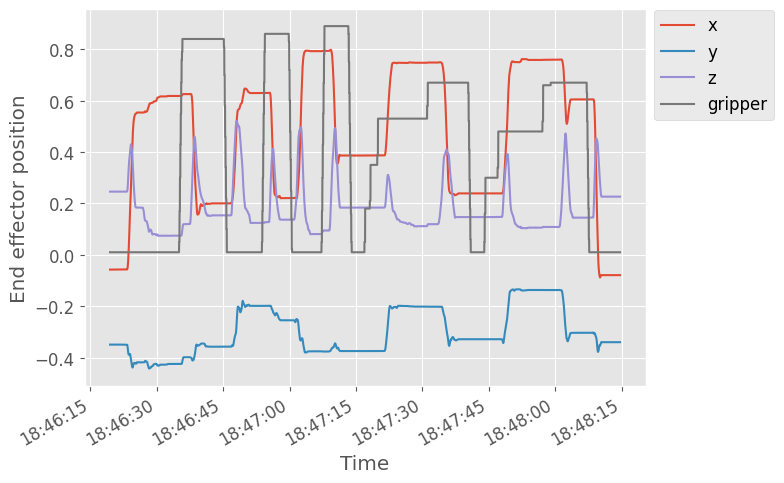

In [13]:
with plt.style.context("ggplot_perso.mplstyle"):
    # with plt.style.context("ggplot"):
    fig, ax = plt.subplots(figsize=(8, 5))
    # cmap = mpl.colormaps.get("tab10").colors
    ax.plot(traj.timestamp, traj.x, label="x")  # , color=cmap[0])
    ax.plot(traj.timestamp, traj.y, label="y")  # , color=cmap[1])
    ax.plot(traj.timestamp, traj.z, label="z")  # , color=cmap[2])
    ax.plot(traj.timestamp, traj.gripper, label="gripper")  # , color=cmap[3])
    ax.set_xlabel("Time")
    ax.set_ylabel("End effector position")
    # ax.legend(loc="best")
    ax.legend(bbox_to_anchor=(1.0, 1.02))
    fig.autofmt_xdate()
    fig.tight_layout()
    plt.show()

## Ground truth segmentation

In [14]:
gt_segm_dict = get_ground_truth_segmentation(
    ground_truth_segm_file=ground_truth_segm_file, bagfile=bagfile
)
gt_segm_dict

{'filename': 'rosbag2_2025-09-08_19-46-18_2025-09-08-19-46-19.bag',
 'HigherLevel': {'plate': {'ini': 1757375183, 'end': 1757375205},
  'cup': {'ini': 1757375207, 'end': 1757375220},
  'napkin': {'ini': 1757375220, 'end': 1757375232},
  'spoon': {'ini': 1757375235, 'end': 1757375258},
  'fork': {'ini': 1757375262, 'end': 1757375288}},
 'LowerLevel': {'reaching': [{'ini': 1757375183, 'end': 1757375194},
   {'ini': 1757375207, 'end': 1757375212},
   {'ini': 1757375220, 'end': 1757375226},
   {'ini': 1757375235, 'end': 1757375253},
   {'ini': 1757375262, 'end': 1757375280}],
  'placing': [{'ini': 1757375197, 'end': 1757375205},
   {'ini': 1757375215, 'end': 1757375220},
   {'ini': 1757375228, 'end': 1757375232},
   {'ini': 1757375253, 'end': 1757375258},
   {'ini': 1757375280, 'end': 1757375288}]}}

### Higher level movements

In [15]:
# with plt.style.context("ggplot_perso.mplstyle"):
#     fig, ax = plt.subplots(figsize=(11, 7))
#     cmap = mpl.colormaps.get("Pastel2").colors
#     ax.plot(traj.timestamp, traj.x, label="x")  # , color=cmap[0])
#     ax.plot(traj.timestamp, traj.y, label="y")  # , color=cmap[1])
#     ax.plot(traj.timestamp, traj.z, label="z")  # , color=cmap[2])
#     ax.plot(traj.timestamp, traj.gripper, label="gripper")  # , color=cmap[3])

#     fill_min = np.min([traj.x.min(), traj.y.min(), traj.z.min(), traj.gripper.min()])
#     fill_max = np.max([traj.x.max(), traj.y.max(), traj.z.max(), traj.gripper.max()])
#     for sect_i, sect_key in enumerate(gt_segm_dict["HigherLevel"].keys()):
#         sect_dict_current = gt_segm_dict["HigherLevel"][sect_key]
#         xs = traj.timestamp[
#             (
#                 traj.timestamp
#                 > pd.Timestamp(
#                     dt.datetime.fromtimestamp(sect_dict_current["ini"])
#                     - dt.timedelta(hours=1),
#                     tz="EST",
#                 )
#             )
#             & (
#                 traj.timestamp
#                 < pd.Timestamp(
#                     dt.datetime.fromtimestamp(sect_dict_current["end"])
#                     - dt.timedelta(hours=1),
#                     tz="EST",
#                 )
#             )
#         ]  # - dt.timedelta(hours=5)
#         ax.fill_between(
#             x=xs,
#             y1=fill_min - 1,
#             y2=fill_max + 1,
#             color=cmap[sect_i],
#             alpha=0.5,
#             transform=ax.get_xaxis_transform(),
#             label=sect_key,
#         )

#     ax.set_ylim(bottom=fill_min - 0.1, top=fill_max + 0.1)
#     ax.set_xlabel("Time")
#     ax.set_ylabel("End effector position")
#     ax.legend(bbox_to_anchor=(1.0, 1.02))
#     ax.set_title("Ground truth clustering")
#     fig.autofmt_xdate()
#     fig.tight_layout()
#     plt.show()

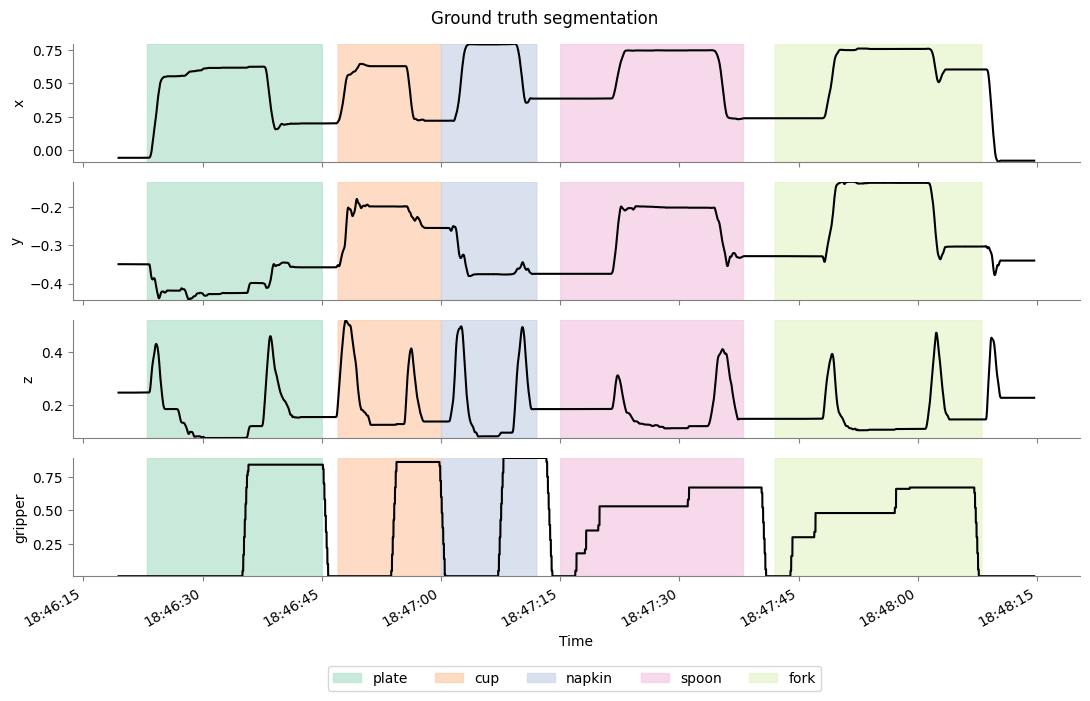

In [16]:
df_labels = list(traj.drop(columns=["timestamp"]).keys())
fig, axes = plt.subplots(
    nrows=len(df_labels), ncols=1, sharex=True, sharey=False, figsize=(11, 7)
)
cmap = mpl.colormaps.get("Pastel2").colors
for idx, ax in enumerate(axes):
    ax.plot(traj.timestamp, traj[df_labels[idx]], "k")
    ax.set_ylabel(df_labels[idx])
    ax.spines[["right", "top"]].set_visible(False)

    y_low = traj[df_labels[idx]].min()
    y_high = traj[df_labels[idx]].max()
    ax.set_ylim(bottom=y_low, top=y_high)
    ax.tick_params(color="gray")
    for spine in ax.spines.values():
        spine.set_edgecolor("gray")

    for sect_i, sect_key in enumerate(gt_segm_dict["HigherLevel"].keys()):
        sect_dict_current = gt_segm_dict["HigherLevel"][sect_key]
        xs = traj.timestamp[
            (
                traj.timestamp
                > pd.Timestamp(
                    dt.datetime.fromtimestamp(sect_dict_current["ini"])
                    - dt.timedelta(hours=1),
                    tz="EST",
                )
            )
            & (
                traj.timestamp
                < pd.Timestamp(
                    dt.datetime.fromtimestamp(sect_dict_current["end"])
                    - dt.timedelta(hours=1),
                    tz="EST",
                )
            )
        ]  # - dt.timedelta(hours=5)
        ax.fill_between(
            x=xs,
            y1=y_low,
            y2=y_high,
            color=cmap[sect_i],
            alpha=0.7,
            # transform=ax.get_xaxis_transform(),
            label=sect_key,
        )

axes[-1].set_xlabel("Time")
# axes[0].legend(bbox_to_anchor=(1.0, 1.02))
axes[-1].legend(
    bbox_to_anchor=(0.75, -0.7), ncol=len(gt_segm_dict["HigherLevel"].keys())
)
fig.suptitle("Ground truth segmentation")
fig.autofmt_xdate()
fig.tight_layout()
plt.show()

### Lower level movements

In [17]:
# with plt.style.context("ggplot_perso.mplstyle"):
#     fig, ax = plt.subplots(figsize=(11, 7))
#     cmap = mpl.colormaps.get("Pastel2").colors
#     ax.plot(traj.timestamp, traj.x, label="x")  # , color=cmap[0])
#     ax.plot(traj.timestamp, traj.y, label="y")  # , color=cmap[1])
#     ax.plot(traj.timestamp, traj.z, label="z")  # , color=cmap[2])
#     ax.plot(traj.timestamp, traj.gripper, label="gripper")  # , color=cmap[3])

#     fill_min = np.min([traj.x.min(), traj.y.min(), traj.z.min(), traj.gripper.min()])
#     fill_max = np.max([traj.x.max(), traj.y.max(), traj.z.max(), traj.gripper.max()])
#     for sect_i, sect_key in enumerate(gt_segm_dict["LowerLevel"].keys()):
#         skill_current = gt_segm_dict["LowerLevel"][sect_key]
#         for skill_i, skill_val in enumerate(skill_current):
#             xs = traj.timestamp[
#                 (
#                     traj.timestamp
#                     > pd.Timestamp(
#                         dt.datetime.fromtimestamp(skill_val["ini"])
#                         - dt.timedelta(hours=1),
#                         tz="EST",
#                     )
#                 )
#                 & (
#                     traj.timestamp
#                     < pd.Timestamp(
#                         dt.datetime.fromtimestamp(skill_val["end"])
#                         - dt.timedelta(hours=1),
#                         tz="EST",
#                     )
#                 )
#             ]  # - dt.timedelta(hours=5)
#             if skill_i == 0:
#                 ax.fill_between(
#                     x=xs,
#                     y1=fill_min - 1,
#                     y2=fill_max + 1,
#                     color=cmap[sect_i],
#                     alpha=0.5,
#                     transform=ax.get_xaxis_transform(),
#                     label=sect_key,
#                 )
#             else:
#                 ax.fill_between(
#                     x=xs,
#                     y1=fill_min - 1,
#                     y2=fill_max + 1,
#                     color=cmap[sect_i],
#                     alpha=0.5,
#                     transform=ax.get_xaxis_transform(),
#                     # label=sect_key,
#                 )

#     ax.set_ylim(bottom=fill_min - 0.1, top=fill_max + 0.1)
#     ax.set_xlabel("Time")
#     ax.set_ylabel("End effector position")
#     ax.legend(bbox_to_anchor=(1.0, 1.02))
#     ax.set_title("Ground truth clustering")
#     fig.autofmt_xdate()
#     fig.tight_layout()
#     plt.show()

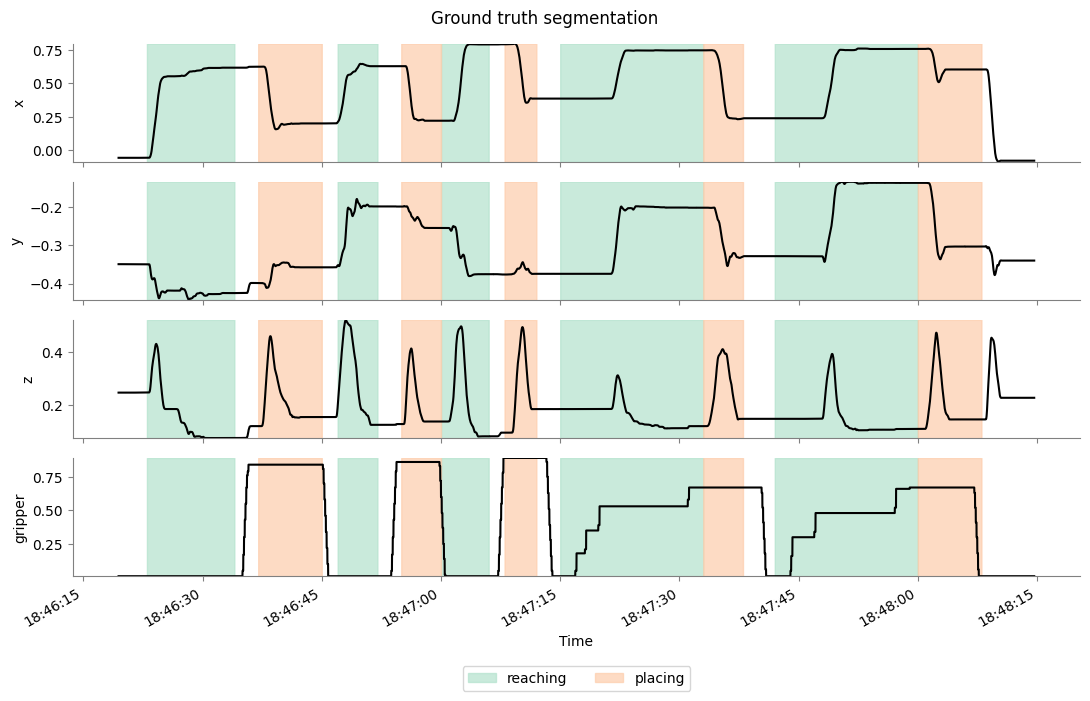

In [18]:
df_labels = list(traj.drop(columns=["timestamp"]).keys())
fig, axes = plt.subplots(
    nrows=len(df_labels), ncols=1, sharex=True, sharey=False, figsize=(11, 7)
)
cmap = mpl.colormaps.get("Pastel2").colors
for idx, ax in enumerate(axes):
    ax.plot(traj.timestamp, traj[df_labels[idx]], "k")
    ax.set_ylabel(df_labels[idx])
    ax.spines[["right", "top"]].set_visible(False)

    y_low = traj[df_labels[idx]].min()
    y_high = traj[df_labels[idx]].max()
    ax.set_ylim(bottom=y_low, top=y_high)
    ax.tick_params(color="gray")
    for spine in ax.spines.values():
        spine.set_edgecolor("gray")

    for sect_i, sect_key in enumerate(gt_segm_dict["LowerLevel"].keys()):
        skill_current = gt_segm_dict["LowerLevel"][sect_key]
        for skill_i, skill_val in enumerate(skill_current):
            xs = traj.timestamp[
                (
                    traj.timestamp
                    > pd.Timestamp(
                        dt.datetime.fromtimestamp(skill_val["ini"])
                        - dt.timedelta(hours=1),
                        tz="EST",
                    )
                )
                & (
                    traj.timestamp
                    < pd.Timestamp(
                        dt.datetime.fromtimestamp(skill_val["end"])
                        - dt.timedelta(hours=1),
                        tz="EST",
                    )
                )
            ]  # - dt.timedelta(hours=5)
            if skill_i == 0:
                ax.fill_between(
                    x=xs,
                    y1=y_low,
                    y2=y_high,
                    color=cmap[sect_i],
                    alpha=0.7,
                    # transform=ax.get_xaxis_transform(),
                    label=sect_key,
                )
            else:
                ax.fill_between(
                    x=xs,
                    y1=y_low,
                    y2=y_high,
                    color=cmap[sect_i],
                    alpha=0.7,
                    # transform=ax.get_xaxis_transform(),
                )

axes[-1].set_xlabel("Time")
# axes[0].legend(bbox_to_anchor=(1.0, 1.02))
axes[-1].legend(
    bbox_to_anchor=(0.62, -0.7), ncol=len(gt_segm_dict["LowerLevel"].keys())
)
fig.suptitle("Ground truth segmentation")
fig.autofmt_xdate()
fig.tight_layout()
plt.show()

## Segmentation

### Preprocessing

In [19]:
downsampling_factor = 200

In [20]:
# true_cps = np.ones((len(gt_segm_dict["HigherLevel"]) - 1)) * np.nan
# for sect_i, sect_key in enumerate(gt_segm_dict["HigherLevel"].keys()):
#     sect_dict_current = gt_segm_dict["HigherLevel"][sect_key]
#     if sect_i < len(true_cps):
#         true_cps[sect_i] = sect_dict_current["end"]
# true_cps

In [21]:
what_segments = "HigherLevel"
# what_segments = "LowerLevel"

labels = gt_segm_dict[what_segments].keys()
labels

dict_keys(['plate', 'cup', 'napkin', 'spoon', 'fork'])

In [22]:
X = traj.drop(columns=["timestamp"])
X

,x,y,z,gripper
0,-0.057518,-0.349359,0.245916,0.01
1,-0.057527,-0.349371,0.245943,0.01
2,-0.057521,-0.349371,0.245940,0.01
3,-0.057525,-0.349373,0.245945,0.01
4,-0.057515,-0.349382,0.245951,0.01
...,...,...,...,...
57561,-0.079063,-0.339990,0.226383,0.01
57562,-0.079040,-0.339984,0.226385,0.01
57563,-0.079073,-0.339983,0.226388,0.01
57564,-0.079063,-0.339978,0.226381,0.01


In [23]:
def get_closest_ts(traj_ts, query_idx):
    idx2ts = pd.Timestamp(
        dt.datetime.fromtimestamp(query_idx) - dt.timedelta(hours=1),
        tz="EST",
    )
    closest_tdelta = (traj_ts - idx2ts).abs().min()
    idx_res = traj_ts.index[traj_ts == closest_tdelta + idx2ts]
    return idx_res[0]

In [24]:
# Create supervised labels
y = np.ones(shape=X.shape[0]) * np.nan
if what_segments == "HigherLevel":
    for sect_i, sect_key in enumerate(gt_segm_dict[what_segments].keys()):
        sect_dict_current = gt_segm_dict[what_segments][sect_key]
        idx_ini = get_closest_ts(
            traj_ts=traj.timestamp, query_idx=sect_dict_current["ini"]
        )
        idx_end = get_closest_ts(
            traj_ts=traj.timestamp, query_idx=sect_dict_current["end"]
        )
        y[idx_ini:idx_end] = sect_i

elif what_segments == "LowerLevel":
    for sect_i, sect_key in enumerate(gt_segm_dict[what_segments].keys()):
        skill_current = gt_segm_dict[what_segments][sect_key]
        for skill_i, skill_val in enumerate(skill_current):
            idx_ini = get_closest_ts(traj_ts=traj.timestamp, query_idx=skill_val["ini"])
            idx_end = get_closest_ts(traj_ts=traj.timestamp, query_idx=skill_val["end"])
            y[idx_ini:idx_end] = sect_i

else:
    raise ValueError("what_segments can only be 'HigherLevel' or 'LowerLevel'")
y

array([nan, nan, nan, ..., nan, nan, nan], shape=(57566,))

In [25]:
np.unique(y)

array([ 0.,  1.,  2.,  3.,  4., nan])

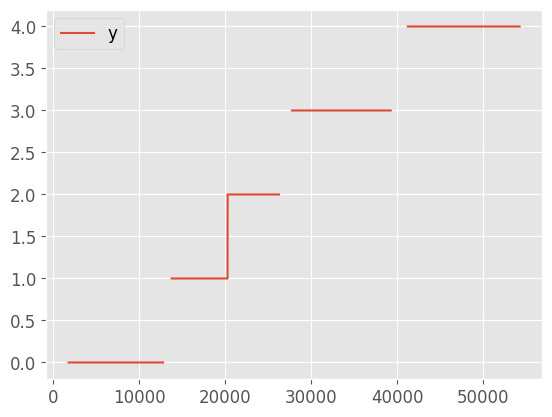

In [26]:
with plt.style.context("ggplot_perso.mplstyle"):
    fig, ax = plt.subplots()  # figsize=(11, 7))
    ax.plot(y, label="y")
    ax.legend(loc="best")
    plt.show()

In [27]:
idx2filter = np.where(~np.isnan(y))
idx2filter

(array([ 1785,  1786,  1787, ..., 54243, 54244, 54245], shape=(47963,)),)

In [28]:
y_filtered = y[idx2filter]
y_filtered

array([0., 0., 0., ..., 4., 4., 4.], shape=(47963,))

In [29]:
np.unique(y_filtered)

array([0., 1., 2., 3., 4.])

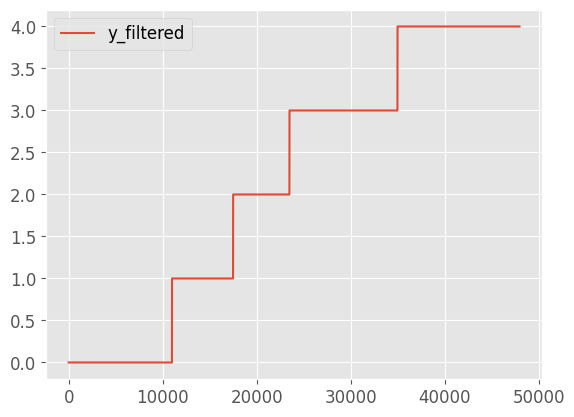

In [30]:
with plt.style.context("ggplot_perso.mplstyle"):
    fig, ax = plt.subplots()  # figsize=(11, 7))
    ax.plot(y_filtered, label="y_filtered")
    ax.legend(loc="best")
    plt.show()

In [31]:
X_filtered = X.iloc[idx2filter]
X_filtered

,x,y,z,gripper
1785,-0.057529,-0.349365,0.245910,0.01
1786,-0.057517,-0.349362,0.245916,0.01
1787,-0.057519,-0.349371,0.245965,0.01
1788,-0.057496,-0.349364,0.245927,0.01
1789,-0.057527,-0.349372,0.245934,0.01
...,...,...,...,...
54241,0.604773,-0.303366,0.144645,0.01
54242,0.604773,-0.303355,0.144652,0.01
54243,0.604772,-0.303351,0.144637,0.01
54244,0.604767,-0.303379,0.144689,0.01


In [32]:
X_scaled = MinMaxScaler(feature_range=(0, 1)).fit_transform(X_filtered)
X_scaled

array([[2.03462542e-05, 3.02970248e-01, 3.84556711e-01, 0.00000000e+00],
       [3.37339936e-05, 3.02978356e-01, 3.84570559e-01, 0.00000000e+00],
       [3.12934476e-05, 3.02949718e-01, 3.84679761e-01, 0.00000000e+00],
       ...,
       [7.73938439e-01, 4.52026190e-01, 1.57855692e-01, 0.00000000e+00],
       [7.73931971e-01, 4.51937085e-01, 1.57972680e-01, 0.00000000e+00],
       [7.73951043e-01, 4.51959832e-01, 1.57998140e-01, 0.00000000e+00]],
      shape=(47963, 4))

In [33]:
X_down = signal.decimate(x=X_filtered, q=downsampling_factor, axis=0)
X_down.shape

(240, 4)

In [34]:
minmaxscaler = MinMaxScaler(feature_range=(0, 1))
X_down_scaled = minmaxscaler.fit_transform(X_down)
X_down_scaled.shape

(240, 4)

In [35]:
np.any(np.isinf(X_down_scaled)), np.any(np.isnan(X_down_scaled))

(np.False_, np.False_)

In [36]:
y_down = np.round(signal.decimate(x=y_filtered, q=downsampling_factor, axis=0)).astype(
    int
)
y_down

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4])

In [37]:
np.unique(y_down)

array([0, 1, 2, 3, 4])

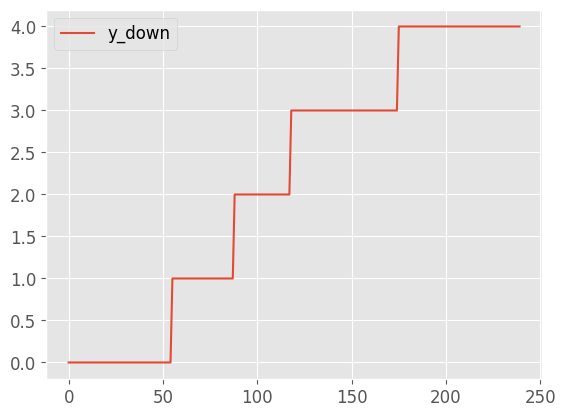

In [38]:
with plt.style.context("ggplot_perso.mplstyle"):
    fig, ax = plt.subplots()  # figsize=(11, 7))
    ax.plot(y_down, label="y_down")
    ax.legend(loc="best")
    plt.show()

In [39]:
# timestamp_down = traj.timestamp[
#     np.arange(start=traj.index.start, stop=traj.index.stop, step=downsampling_factor)
# ]
# timestamp_down

### Conditional Random Field

In [40]:
supervised_classes = torch.tensor(y_down, dtype=int)
supervised_observations = torch.tensor(X_down_scaled)

In [41]:
supervised_classes.shape, supervised_observations.shape

(torch.Size([240]), torch.Size([240, 4]))

In [42]:
supervised_classes

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4])

In [43]:
supervised_observations.dtype

torch.float64

In [44]:
num_hidden_states = len(labels)  # number of hidden states
num_features = X.shape[1]  # number of continuous features

In [45]:
class CRF(nn.Module):
    def __init__(self, num_tags):
        super(CRF, self).__init__()
        self.num_tags = num_tags
        # Transition matrix: transition[i][j] is the score of transitioning from j to i
        self.transitions = nn.Parameter(torch.randn(num_tags, num_tags))

    def forward(self, emissions, tags):
        # emissions: (batch_size, seq_length, num_tags)
        # tags: (batch_size, seq_length)
        if len(tags.shape) < 2:
            tags = tags.unsqueeze(dim=0)
        batch_size, seq_length = tags.size()
        # Calculate the numerator score
        numerator_score = self._compute_score(emissions, tags)
        # Calculate the denominator score
        denominator_score = self._compute_normalizer(emissions)

        return -torch.mean(numerator_score - denominator_score)

    def _compute_score(self, emissions, tags):
        if len(emissions.shape) < 3:
            emissions = emissions.unsqueeze(dim=0)
        batch_size, seq_length, num_tags = emissions.size()
        score = torch.zeros(batch_size)

        # Add the start transition score
        start_transitions = self.transitions[tags[:, 0], torch.tensor([0] * batch_size)]
        score += start_transitions

        # Add the emission scores and transition scores for each step
        for i in range(seq_length - 1):
            current_tags = tags[:, i]
            next_tags = tags[:, i + 1]
            score += emissions[torch.arange(batch_size), i, current_tags]
            score += self.transitions[next_tags, current_tags]

        # Add the end emission score
        score += emissions[
            torch.arange(batch_size), seq_length - 1, tags[:, seq_length - 1]
        ]

        return score

    def _compute_normalizer(self, emissions):
        if len(emissions.shape) < 3:
            emissions = emissions.unsqueeze(dim=0)
        batch_size, seq_length, num_tags = emissions.size()
        alphas = emissions[:, 0, :]

        for i in range(1, seq_length):
            emit_scores = emissions[:, i].unsqueeze(1)
            trans_scores = self.transitions.unsqueeze(0)
            next_alphas = alphas.unsqueeze(2) + emit_scores + trans_scores
            next_alphas = torch.logsumexp(next_alphas, dim=1)
            alphas = next_alphas

        return torch.logsumexp(alphas, dim=1)

In [46]:
supervised_classes.unsqueeze(dim=0).shape

torch.Size([1, 240])

In [47]:
class SimpleCRFModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_tags):
        super(SimpleCRFModel, self).__init__()
        self.fc = nn.Linear(input_size, hidden_size, dtype=float)
        self.relu = nn.ReLU()
        self.emission_layer = nn.Linear(hidden_size, num_tags, dtype=float)
        self.crf = CRF(num_tags)

    def forward(self, inputs, tags):
        x = self.fc(inputs)
        x = self.relu(x)
        emissions = self.emission_layer(x)
        loss = self.crf(emissions, tags)
        return loss

    def predict(self, inputs):
        """Predict the most probable sequence of tags"""
        with torch.no_grad():
            x = self.fc(inputs)
            x = self.relu(x)
            emissions = self.emission_layer(x)
            best_paths = viterbi_decode(
                emissions=emissions, transitions=self.crf.transitions
            )
            return best_paths.squeeze()

### Training

#### Hyperparameters

In [48]:
# batch_size = 4
seq_length = len(supervised_classes)
num_tags = len(labels)
input_size = num_features

In [49]:
# # Generate some sample data
# inputs = torch.randn(batch_size, seq_length, input_size)
# tags = torch.randint(0, num_tags, (batch_size, seq_length))

In [50]:
# Hyperparameters
learning_rate = 0.01
weight_decay = 0.001
num_epochs = 200
crf_hidden_size = 50

In [51]:
# Initialize the model
model = SimpleCRFModel(
    input_size=input_size, hidden_size=crf_hidden_size, num_tags=num_tags
)

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

losses = []
for epoch in tqdm(range(num_epochs)):
    optimizer.zero_grad()
    loss = model(inputs=supervised_observations, tags=supervised_classes)
    losses.append(loss.item())
    loss.backward()
    optimizer.step()

  0%|          | 0/200 [00:00<?, ?it/s]

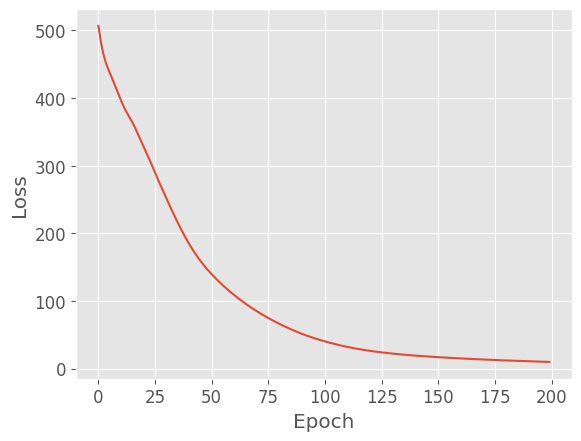

In [52]:
with plt.style.context("ggplot_perso.mplstyle"):
    fig, ax = plt.subplots()
    epochs = np.arange(num_epochs)
    ax.plot(epochs, losses)
    ax.set_ylabel("Loss")
    ax.set_xlabel("Epoch")
    plt.show()

In [53]:
# def viterbi_decode(emissions, transitions):
#     batch_size, seq_length, num_tags = emissions.size()
#     alphas = emissions[:, 0, :]
#     backpointers = []

#     for i in range(1, seq_length):
#         emit_scores = emissions[:, i].unsqueeze(1)
#         trans_scores = transitions.unsqueeze(0)
#         next_alphas = alphas.unsqueeze(2) + emit_scores + trans_scores
#         max_scores, max_indices = torch.max(next_alphas, dim=1)
#         alphas = max_scores
#         backpointers.append(max_indices)

#     best_path_scores, best_last_tags = torch.max(alphas, dim=1)
#     best_paths = []
#     for i in range(batch_size):
#         best_path = [best_last_tags[i].item()]
#         for bp in reversed(backpointers):
#             best_path.append(bp[i, best_path[-1]].item())
#         best_path.reverse()
#         best_paths.append(best_path)

#     return best_paths

In [54]:
def viterbi_decode(emissions, transitions):
    if len(emissions.shape) < 3:
        emissions = emissions.unsqueeze(dim=0)
    batch_size, seq_length, num_tags = emissions.size()
    # Initialize with first position emissions + transition from tag 0 (START)
    alphas = emissions[:, 0, :] + transitions[:, 0].unsqueeze(0)
    backpointers = []

    for i in range(1, seq_length):
        emit_scores = emissions[:, i].unsqueeze(1)
        trans_scores = transitions.unsqueeze(0)
        next_alphas = alphas.unsqueeze(2) + emit_scores + trans_scores
        max_scores, max_indices = torch.max(next_alphas, dim=1)
        alphas = max_scores
        backpointers.append(max_indices)

    best_path_scores, best_last_tags = torch.max(alphas, dim=1)
    best_paths = []
    for i in range(batch_size):
        best_path = [best_last_tags[i].item()]
        for bp in reversed(backpointers):
            best_path.append(bp[i, best_path[-1]].item())
        best_path.reverse()
        best_paths.append(best_path)

    return torch.tensor(best_paths)

In [55]:
model.eval()
best_paths = model.predict(supervised_observations)
print(f"True classes:\n{supervised_classes}")
print(f"Predicted classes:\n{best_paths}")

True classes:
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4])
Predicted classes:
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
      

In [56]:
# best_paths = best_paths.squeeze()
best_paths.shape, supervised_classes.shape

(torch.Size([240]), torch.Size([240]))

### Metrics & visualization

In [57]:
accu = accuracy_score(y_true=supervised_classes.flatten(), y_pred=best_paths.flatten())
f1 = f1_score(
    y_true=supervised_classes.flatten(), y_pred=best_paths.flatten(), average="macro"
)
print(f"Accuracy: {accu}")
print(f"F1: {f1}")

Accuracy: 0.9958333333333333
F1: 0.9953963593658249


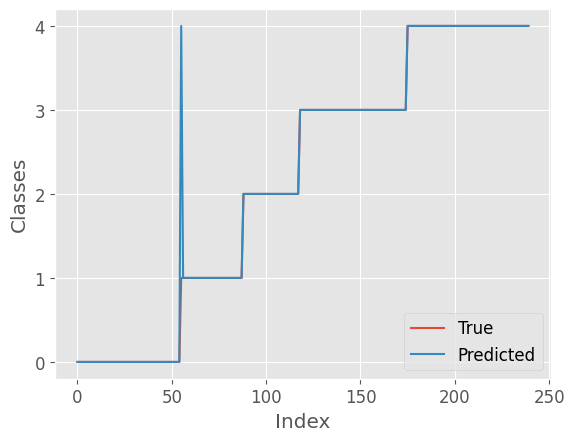

In [58]:
with plt.style.context("ggplot_perso.mplstyle"):
    fig, ax = plt.subplots()  # figsize=(11, 7))
    ax.plot(supervised_classes, label="True")
    ax.plot(best_paths, label="Predicted")
    ax.legend(loc="best")
    ax.set_ylabel("Classes")
    ax.set_xlabel("Index")
    ax.yaxis.set_major_locator(mpl.ticker.FixedLocator(supervised_classes.unique()))
    ax.yaxis.set_major_formatter(
        mpl.ticker.FixedFormatter(
            [str(elem.item()) for elem in supervised_classes.unique()]
        )
    )
    plt.show()

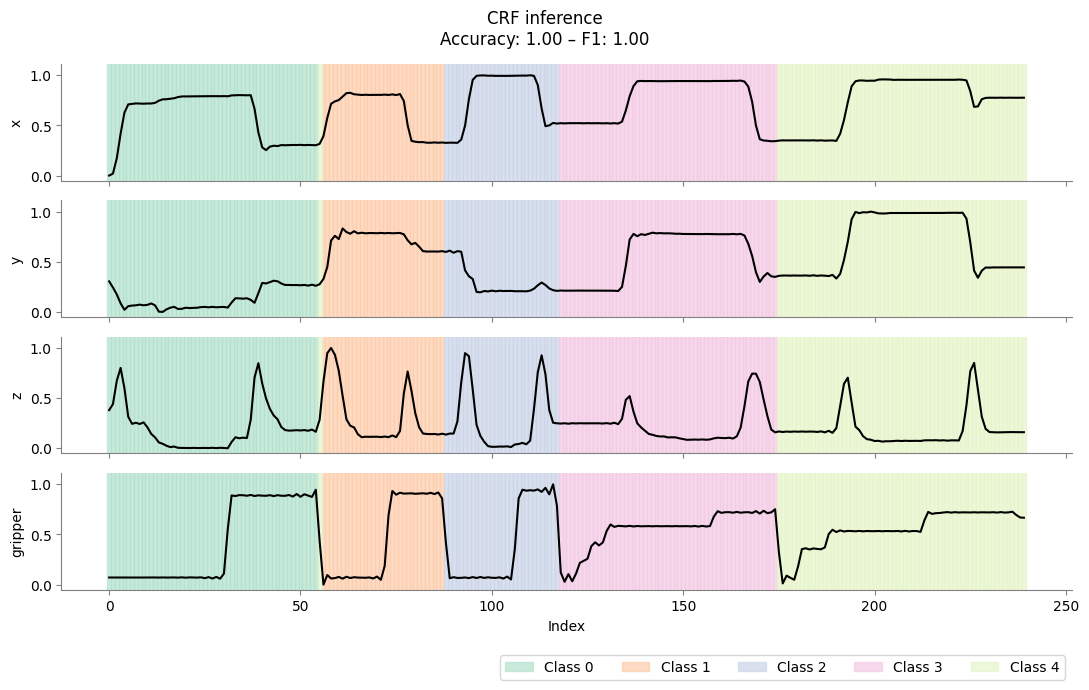

In [59]:
fig, axes = plt.subplots(
    nrows=supervised_observations.shape[1], ncols=1, sharex=True, figsize=(11, 7)
)
cmap = mpl.colormaps.get("Pastel2").colors
labels = list(traj.drop(columns=["timestamp"]).keys())
ts = torch.arange(end=supervised_observations.shape[0])
for idx, ax in enumerate(axes):
    ax.plot(supervised_observations[:, idx], "k")  # , color=cmap[0])
    ax.set_ylabel(labels[idx])
    ax.spines[["right", "top"]].set_visible(False)
    ax.tick_params(color="gray")
    for spine in ax.spines.values():
        spine.set_edgecolor("gray")

    # fill_min = np.min([traj.x.min(), traj.y.min(), traj.z.min(), traj.gripper.min()])
    # fill_max = np.max([traj.x.max(), traj.y.max(), traj.z.max(), traj.gripper.max()])
    #     ax.fill_between(
    #         x=xs,
    #         y1=fill_min - 1,
    #         y2=fill_max + 1,
    #         color=cmap[sect_i],
    #         alpha=0.5,
    #         transform=ax.get_xaxis_transform(),
    #         label=sect_key,
    #     )
    y_low, y_high = ax.get_ylim()
    y_mid = torch.tensor([y_low, y_high]).mean().item()
    # y_height = 0.05 * (y_high - y_low)
    y_height = y_high - y_low
    for jdx, class_id in enumerate(supervised_classes.unique()):
        xs = ts[best_paths == class_id]
        for zdx, xi in enumerate(xs):
            if zdx == 0:
                ax.fill_between(
                    # [x - 1, x],
                    [xi - 0.5, xi + 0.5],
                    [y_mid - y_height] * 2,
                    [y_mid + y_height] * 2,
                    alpha=0.7,
                    color=cmap[jdx],
                    label=f"Class {class_id}",
                )
            else:
                ax.fill_between(
                    # [x - 1, x],
                    [xi - 0.5, xi + 0.5],
                    [y_mid - y_height] * 2,
                    [y_mid + y_height] * 2,
                    alpha=0.7,
                    color=cmap[jdx],
                )
    ax.set_ylim(bottom=y_low * 1.01, top=y_height * 1.01)
axes[-1].set_xlabel("Index")
# axes[0].legend(bbox_to_anchor=(1.0, 1.02))
# if what_segments == "LowerLevel":
#     bbox_to_anchor = (0.61, -0.6)
# elif what_segments == "HigherLevel":
#     bbox_to_anchor = (0.8, -0.6)
#     bbox_to_anchor = (1, -0.5)
axes[-1].legend(bbox_to_anchor=(1, -0.5), ncol=len(supervised_classes.unique()))
fig.suptitle(f"CRF inference\nAccuracy: {accu:3.2f} – F1: {f1:3.2f}")
# fig.autofmt_xdate()
fig.tight_layout()
plt.show()

### Validation

In [60]:
def fit_predict_sup_hmm_cont(X_train, y_train, X_test):
    supervised_classes = torch.tensor(y_train, dtype=int)
    supervised_observations = torch.tensor(X_train)
    supervised_obs_test = torch.tensor(X_test)

    # Initialize the model
    model = SimpleCRFModel(
        input_size=input_size, hidden_size=crf_hidden_size, num_tags=num_tags
    )
    model.train()

    # Define the optimizer
    optimizer = optim.Adam(
        model.parameters(), lr=learning_rate, weight_decay=weight_decay
    )

    losses = []
    for epoch in tqdm(range(num_epochs)):
        optimizer.zero_grad()
        loss = model(inputs=supervised_observations, tags=supervised_classes)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()

    # Predict
    model.eval()
    best_paths = model.predict(supervised_obs_test)

    return best_paths

In [61]:
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)
for idx, (train_index, test_index) in enumerate(tscv.split(X_down_scaled)):
    print(f"----- Split {idx + 1}/{n_splits} -----")
    X_train = X_down_scaled[train_index]
    X_test = X_down_scaled[test_index]
    y_train = y_down[train_index]
    y_test = y_down[test_index]

    y_pred = fit_predict_sup_hmm_cont(X_train=X_train, y_train=y_train, X_test=X_test)

    # Metrics
    f1 = f1_score(y_test.flatten(), y_pred.flatten(), average="macro")
    print(f"F1: {f1}")
    accuracy = accuracy_score(y_test.flatten(), y_pred.flatten())
    print(f"Accuracy: {accuracy}")  #:.2f}")
    # logloss_metric = log_loss(y_true=y_test, y_pred=y_pred, labels=np.arange(len(labels)))
    # print(f"Log Loss for 'multi:softprob': {logloss_metric}")#:.4f}")

----- Split 1/5 -----


  0%|          | 0/200 [00:00<?, ?it/s]

F1: 0.2727272727272727
Accuracy: 0.375
----- Split 2/5 -----


  0%|          | 0/200 [00:00<?, ?it/s]

F1: 0.10256410256410256
Accuracy: 0.2
----- Split 3/5 -----


  0%|          | 0/200 [00:00<?, ?it/s]

F1: 0.07407407407407407
Accuracy: 0.125
----- Split 4/5 -----


  0%|          | 0/200 [00:00<?, ?it/s]

F1: 0.12403100775193798
Accuracy: 0.2
----- Split 5/5 -----


  0%|          | 0/200 [00:00<?, ?it/s]

F1: 0.38461538461538464
Accuracy: 0.625
